# Load Data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# define global plot parameters
params = {'axes.labelsize' : 12, 'axes.titlesize' : 12,
          'font.size' : 12, 'legend.fontsize' : 12,
          'xtick.labelsize' : 12, 'ytick.labelsize' : 12}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# connect to database and get data
conn = sqlite3.connect('data/youtube-traceroute.db')

# read necessary tables from database
date_cols = ['dtime']
traceroute = pd.read_sql_query('select unit_id, dtime, source, destination, max(ttl), rtt, status \
                                from traceroute \
                                group by unit_id, dtime, source, destination', 
                               conn, parse_dates = date_cols)
conn.close()

# Split into IPv4 and IPv6

In [3]:
# distinguish between v4 and v6
df_v6 = traceroute[traceroute['source'].str.contains(':')].copy()
df_v4 = traceroute[~traceroute['source'].str.contains(':')].copy()

# Color Encoding

In [4]:
color_codes = {
    'COMPLETED' : 'green',
    'GAPLIMIT' : 'darkkhaki',
    'LOOP' : 'cornflowerblue',
    'UNREACH' : 'darkorchid',
    'ERROR' : 'orange',
    'sum(failed)' : 'red',
    'INCOMPLETED' : 'red'
}

# Pie Charts to show failure distribution

In [5]:
def piechart(dataframe, name, filename):
    
    # get all necessary information
    cnts = dataframe['status'].value_counts()
    freq = cnts.to_dict()
    d = dataframe['status'].value_counts(normalize = True).to_dict()
    dict_summary = dict((str(k),
                         [freq[k], '{:.2%}'.format(v), 0.85 if str(k) == 'COMPLETED' else 0]) for k,v in d.items())

    
    # plotting
    fig, ax = plt.subplots()
    ax.axis('equal')
    explode = [x[2] for label, x in dict_summary.items()]
    ax.pie(
        [cnt[0] for (label, cnt) in dict_summary.items()], 
        colors = [color_codes[k] for k,v in dict_summary.items()], 
        explode = explode, 
        shadow = True
    )


    # labeling and saving
    if name is 'both':
        ax.set_title('Distribution of IPv4 and IPv6 %s traceroute measurements' % sum(cnts), fontsize = 12)
    else:
        ax.set_title('%s traces: %s' % (name, sum(cnts)), fontsize = 12)
        
    
    ax.legend(labels = ["{} ({})".format(label, cnt[1]) for label, cnt in dict_summary.items()], fontsize = 10, loc = 'upper right')
    
    #fig.savefig('plots/%s_distribution.pdf' % filename, bbox_inches = 'tight')

    plt.show()

In [6]:
tmp = traceroute.copy()
# replace all incompleted with common label "INCOMPLETED"
tmp['status'].replace(to_replace = ['UNREACH', 'GAPLIMIT', 'ERROR', 'LOOP'], value = 'INCOMPLETED', inplace = True)

# Distinguish between v4 and v6
tmp_df_v6 = tmp[tmp['source'].str.contains(':')]
tmp_df_v4 = tmp[~tmp['source'].str.contains(':')]

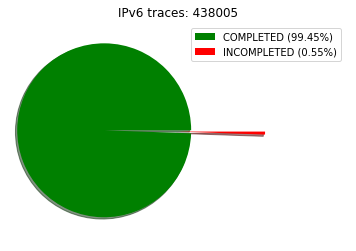

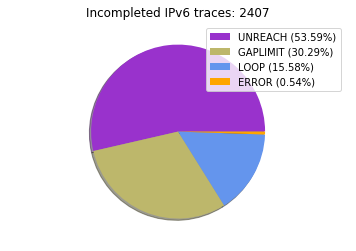

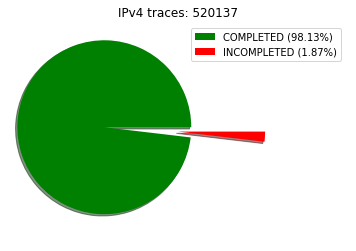

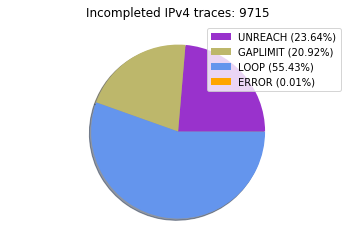

In [7]:
piechart(tmp_df_v6, 'IPv6', 'status_v6_generalized')
piechart(df_v6[~df_v6['status'].str.contains('COMPLETED')], 'Incompleted IPv6', 'status_v6_incomplete')

piechart(tmp_df_v4, 'IPv4', 'status_v4_generalized')
piechart(df_v4[~df_v4['status'].str.contains('COMPLETED')], 'Incompleted IPv4', 'status_v4_incomplete')